In [1]:
import sys
import numpy as np
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import proplot as plot

sys.path.append('/Users/46h/Research/code/accphys')
from tools import envelope_analysis as ea
from tools import plotting as myplt
from tools import animation as myanim
from tools import utils
from tools.utils import show

In [2]:
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['savefig.dpi'] = 'figure'
plot.rc['animation.html'] = 'jshtml'

# 4D Measurement in RTBT
> This notebook reconstructs the beam covariance matrix at the entrance of the Ring to Target Beam Transport (RTBT) section of the Spallation Neutron Source (SNS).

<img src="_fig/rtbt.png" width=800>

## Method summary

The goal is to reconstruct the transverse beam covariance matrix at position $s = s_0$:

$$
\Sigma_{0} = \begin{bmatrix}
    \langle{x^2}\rangle & \langle{xx'}\rangle & \langle{xy}\rangle & \langle{xy'}\rangle \\
    \langle{xx'}\rangle & \langle{{x'}^2}\rangle & \langle{yx'}\rangle & \langle{x'y'}\rangle \\
    \langle{xy}\rangle & \langle{yx'}\rangle & \langle{y^2}\rangle & \langle{yy'}\rangle \\
    \langle{xy'}\rangle & \langle{x'y'}\rangle & \langle{yy'}\rangle & \langle{{y'}^2}\rangle
\end{bmatrix}.
$$

To do this, a set of $n$ wire-scanners can be placed at positions $\{s_i\} > s_0$ with $i = 1, ..., n$. A single measurement from wire-scanner $i$ will produce the real-space moments of the beam at $s_i$: $\langle{x^2}\rangle_{i}$, $\langle{y^2}\rangle_{i}$, and $\langle{xy}\rangle_{i}$. Without space charge, the transfer matrix $M_{s_0 \rightarrow s_i} = M_i$ is known. The moments at $s_0$ are then directly related to those at $s_i$ by

$$\Sigma_i = M_i \Sigma_{0} {M_i}^T.$$ This gives <br>

$$
\begin{align}
    \langle{x^2}\rangle_i &= 
        m_{11}^2\langle{x^2}\rangle_{0} 
      + m_{12}^2\langle{x'^2}\rangle_{0} 
      + 2m_{11}m_{22}\langle{xx'}\rangle_{0} ,\\
    \langle{y^2}\rangle_i &= 
        m_{33}^2\langle{y^2}\rangle_{0} 
      + m_{34}^2\langle{y'^2}\rangle_{0} 
      + 2m_{33}m_{34}\langle{yy'}\rangle_{0} ,\\
    \langle{xy}\rangle_i &= 
        m_{11}m_{33}\langle{xy}\rangle_{0} 
      + m_{12}m_{33}\langle{yx'}\rangle_{0} 
      + m_{11}m_{34}\langle{xy'}\rangle_{0} 
      + m_{12}m_{34}\langle{x'y'}\rangle_{0} ,
\end{align}
$$

where $m_{lm}$ are the elements of the transfer matrix. Taking 3 measurements with different sets of optics between $s_0$ and $s_i$ (and therefore different transfer matrices) gives the 10 equations necessary to solve for $\Sigma_0$; however, real measurements will be noisy, so it is better to take more measurements if possible. Given $N$ measurements, we can form a $3N \times 1$ observation array $b$ from the measured moments and a $3N \times 10$ coefficient array $A$ from the transfer matrix such that

$$\begin{align} \mathbf{A \sigma}_0 = \mathbf{b},\end{align}$$ 

where $\mathbf{\sigma}_0$ is a $10 \times 1$ vector of the moments at $s_0$. There are 5 wire-scanners in the RTBT which operate simultaneously, and it is probably feasible to take around 25 measurements. We then choose $\mathbf{\sigma}_0$ such that $|\mathbf{A\sigma}_0 - \mathbf{b}|^2$ is minimized. 

## RTBT lattice functions 

In [3]:
twiss = pd.read_csv('_output/data/twiss.dat')

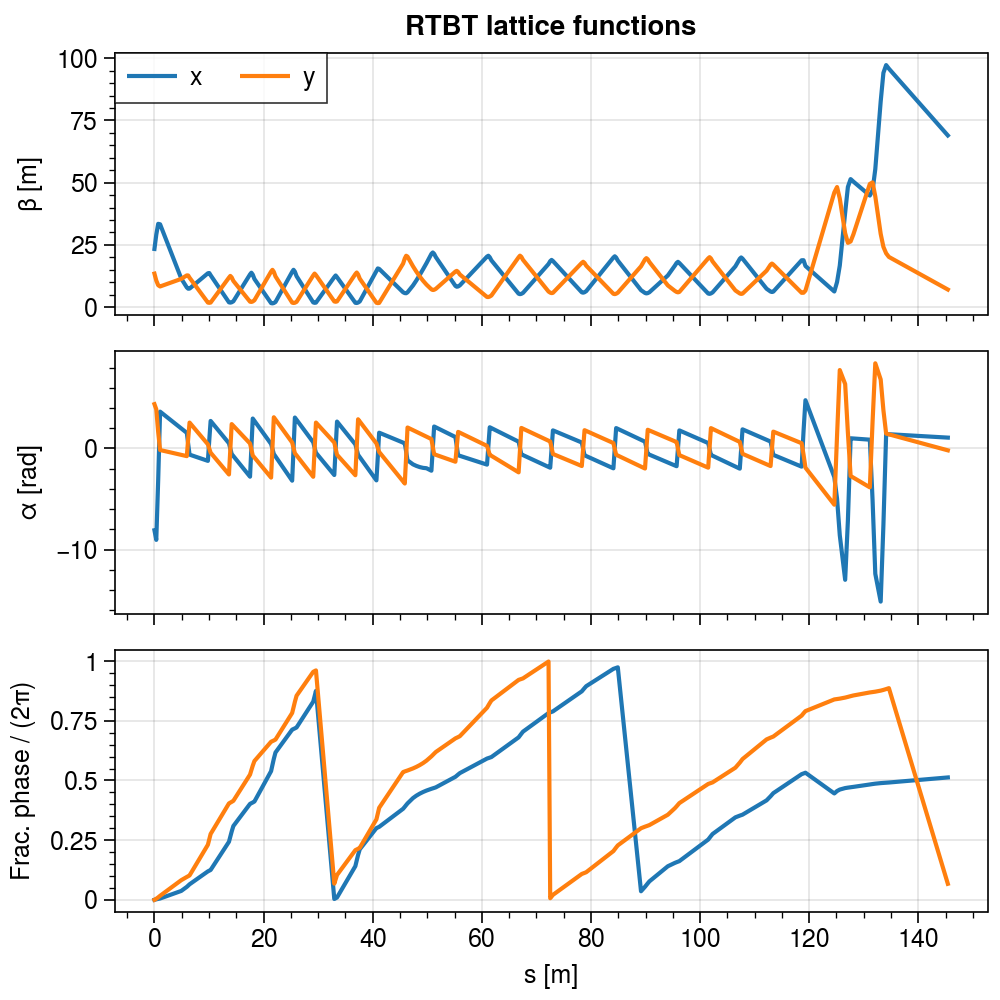

In [4]:
fig, axes = plot.subplots(nrows=3, figsize=(5, 5), spany=False)
ax1, ax2, ax3 = axes
twiss[['s','bx','by']].plot('s', ax=ax1, legend=False)
twiss[['s','ax','ay']].plot('s', ax=ax2, legend=False)
twiss[['s','nux','nuy']].plot('s', ax=ax3, legend=False);
axes.format(xlabel='s [m]', toplabels='RTBT lattice functions')
for ax, ylabel in zip(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', 'Frac. phase / ($2\pi$)']):
    ax.format(ylabel=ylabel);
ax1.legend(labels=['x', 'y']);

## Phase scan 

In [29]:
ws_names = ['ws02', 'ws20', 'ws21', 'ws23', 'ws24']

cov_mats_dict = {}
transfer_mats_dict = {}
phase_advances_dict = {}
env_params_dict = {}
for name in ws_names:
    cov_mats_dict[name] = np.load('_output/data/cov_mats_{}.npy'.format(name))
    transfer_mats_dict[name] = np.load('_output/data/transfer_mats_{}.npy'.format(name))
    phase_advances_dict[name] = np.load('_output/data/phase_advances_{}.npy'.format(name))
    env_params_dict[name] = np.load('_output/data/env_params_{}.npy'.format(name))
    
cov_mats = np.vstack([cov_mats_dict[name] for name in ws_names])
transfer_mats = np.vstack([transfer_mats_dict[name] for name in ws_names])
phase_advances = np.vstack([phase_advances_dict[name] for name in ws_names])
env_params = np.vstack([env_params_dict[name] for name in ws_names])
Sigma0 = np.load('_output/data/Sigma0.npy')

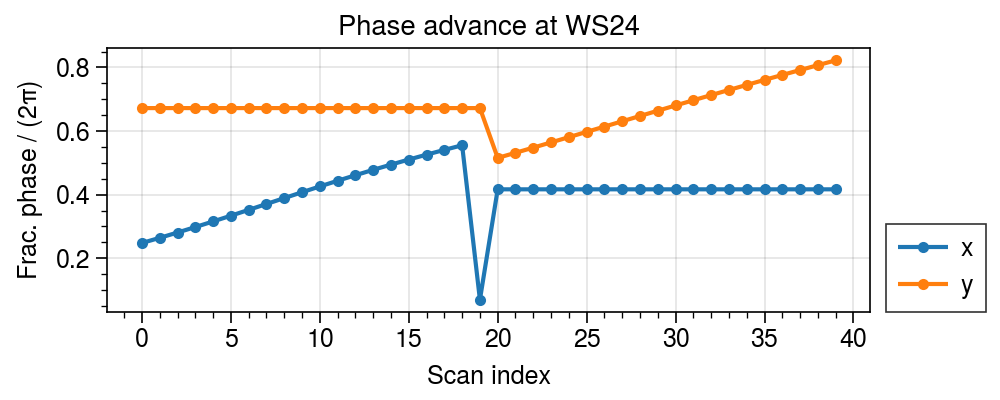

In [20]:
fig, ax = plot.subplots(figsize=(5, 2))
ax.plot(phase_advances_dict['ws24'] % 1, marker='.');
ax.format(ylabel='Frac. phase / ($2\pi$)', xlabel='Scan index', title='Phase advance at WS24')
ax.legend(labels=['x', 'y'], ncols=1, loc=(1.02, 0));

In [21]:
myanim.corner_env(env_params_dict['ws24'], fill=True, text_fmt='Beam at WS\nscan index = {}', figsize=(4.5, 4))

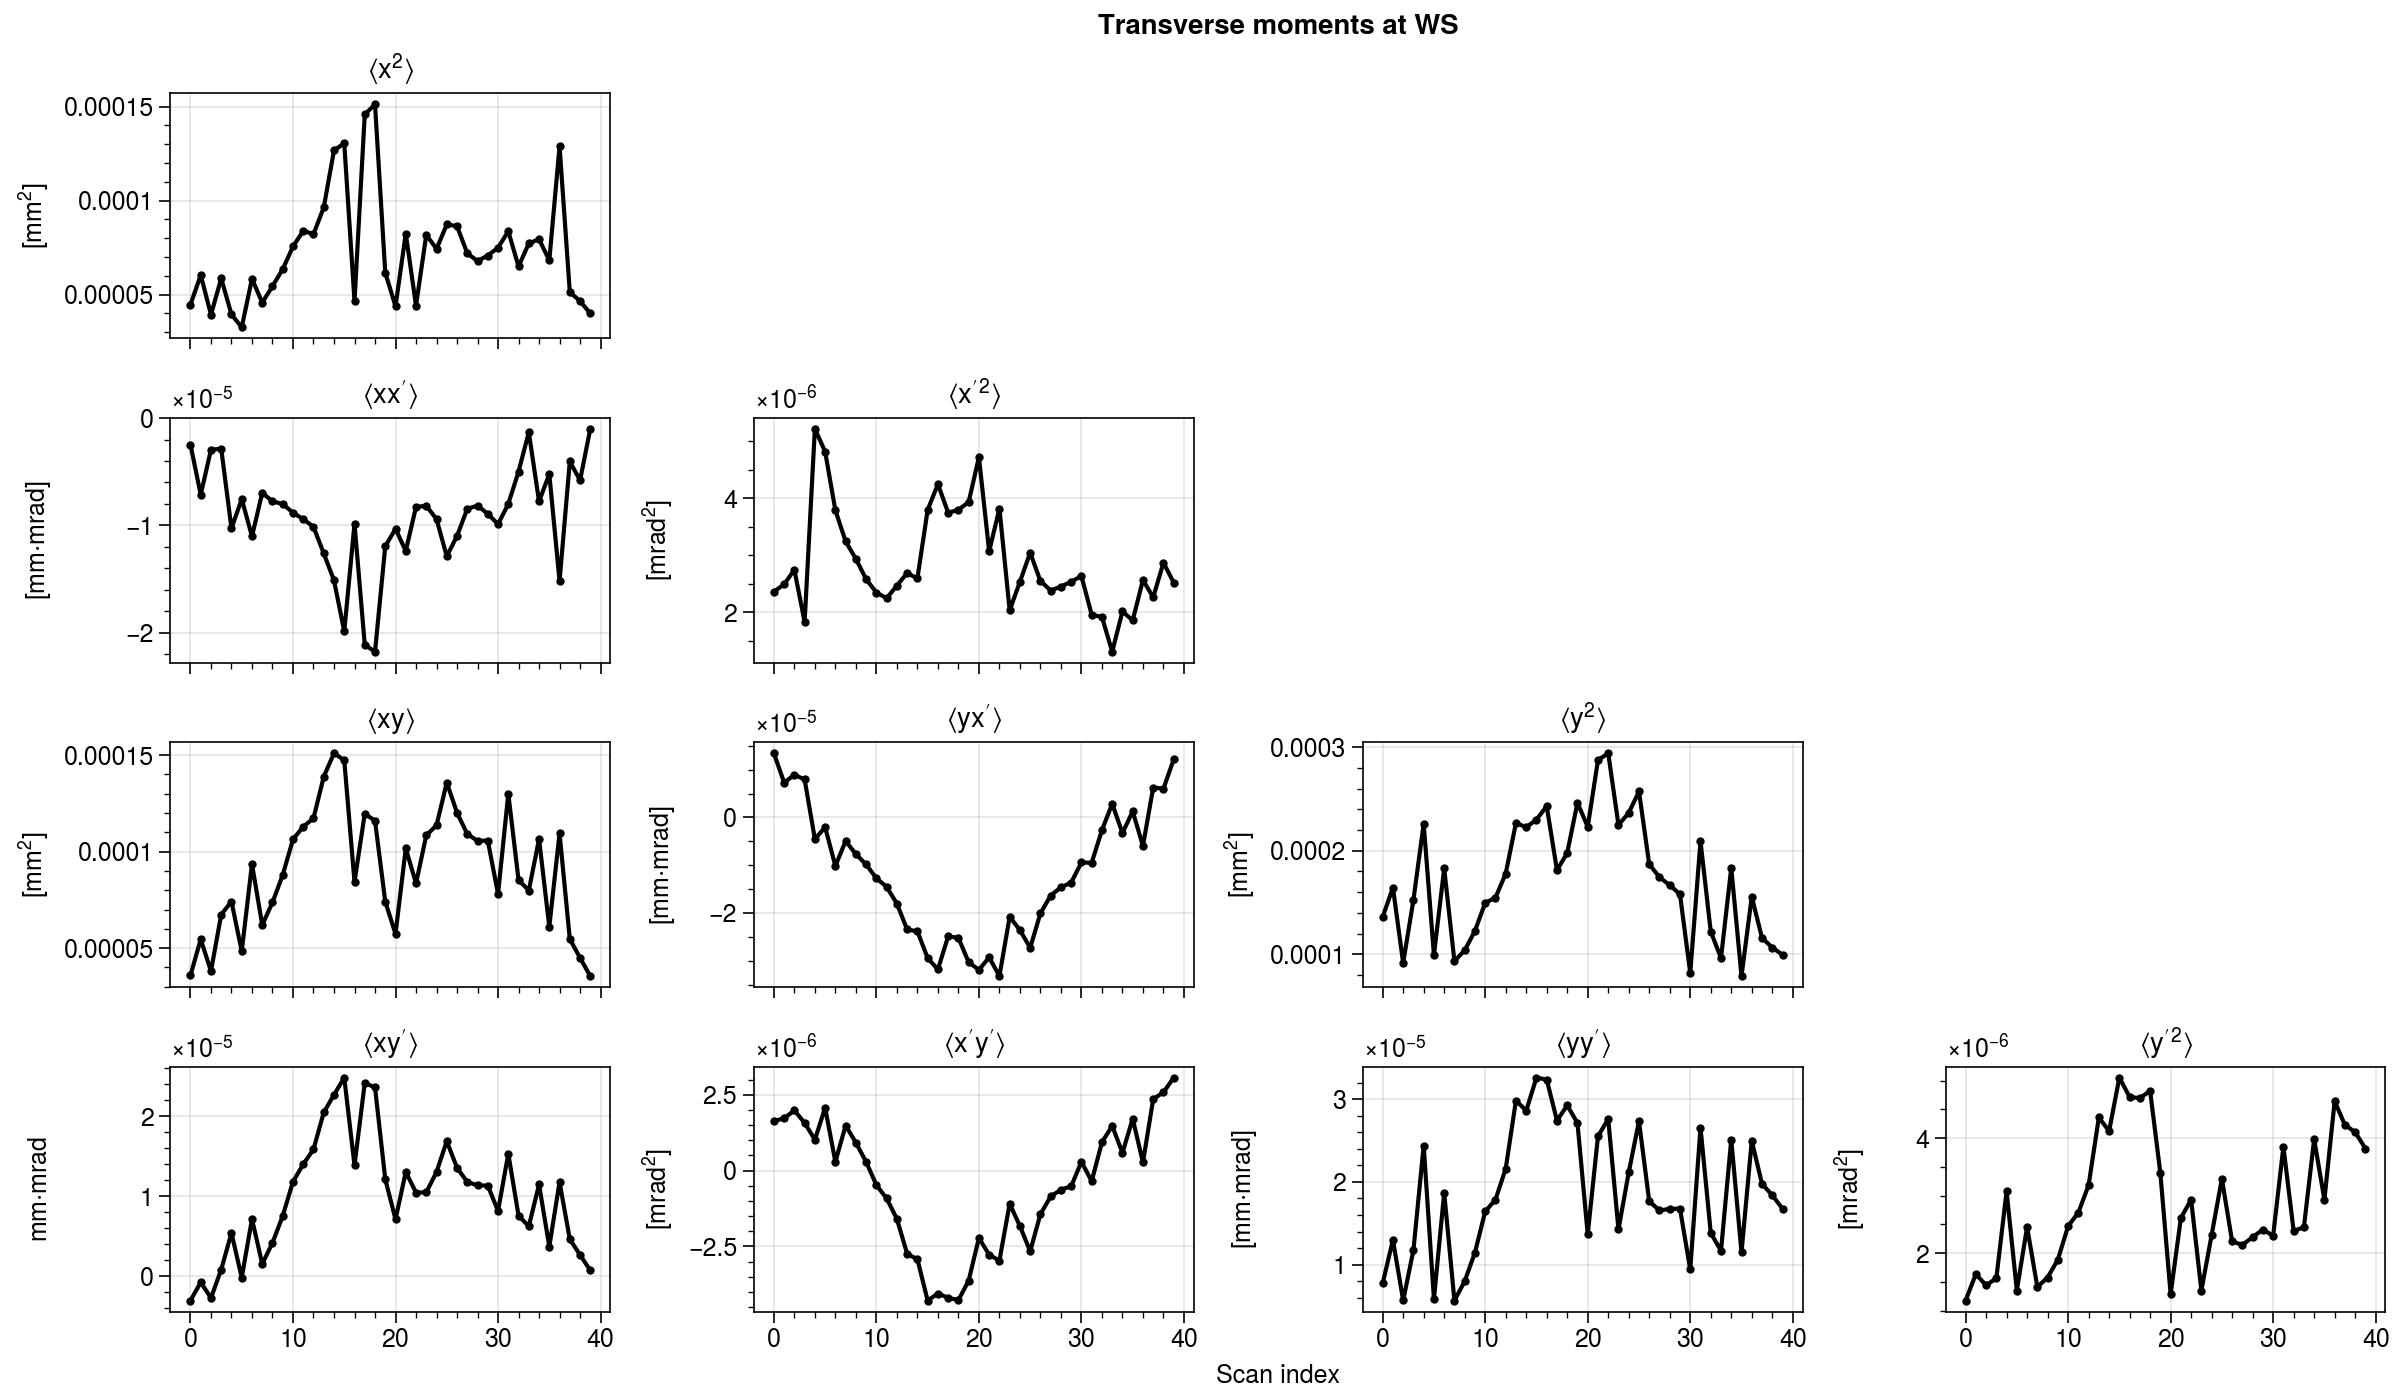

In [22]:
fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(12, 7), 
                          spany=False, aligny=True)
myplt.make_lower_triangular(axes)
axes.format(xlabel='s / L', suptitle='Transverse moments at WS', titleborder=True)
for i in range(4):
    for j in range(i + 1):
        ax = axes[i, j]
        ax.plot(cov_mats_dict['ws24'][:, i, j], color='k', marker='.', ms=4)
        ax.format(title=utils.get_moments_label(i, j), xlabel='Scan index')
myplt.set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
myplt.set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
myplt.set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
myplt.set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')

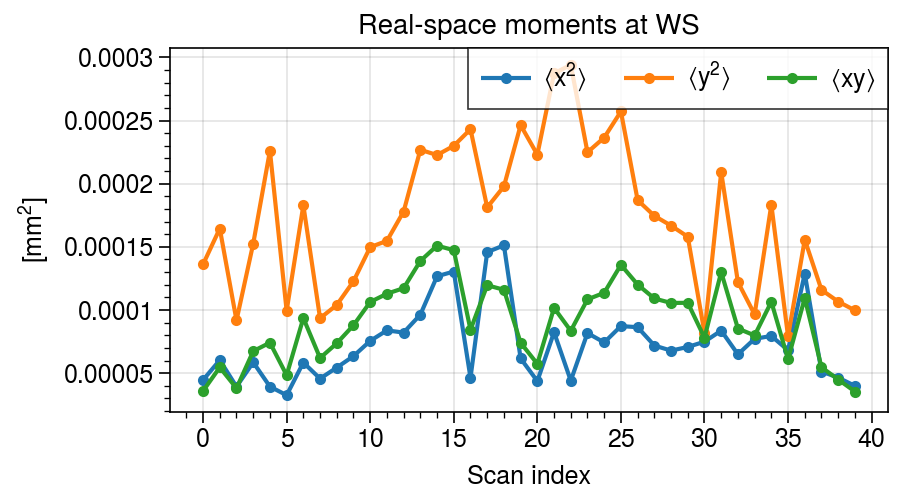

In [24]:
fig, ax = plot.subplots(figsize=(4.5, 2.5))
ax.plot(cov_mats_dict['ws24'][:, 0, 0], marker='.')
ax.plot(cov_mats_dict['ws24'][:, 2, 2], marker='.')
ax.plot(cov_mats_dict['ws24'][:, 0, 2], marker='.')
ax.format(ylabel='[mm$^2$]', xlabel='Scan index', title='Real-space moments at WS')
ax.legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$']);

## Reconstruction

In [25]:
def get_mat(sigma):
    """Return covariance matrix from 10 element moment vector."""
    s11, s22, s12, s33, s44, s34, s13, s23, s14, s24 = sigma
    return np.array([[s11, s12, s13, s14], 
                     [s12, s22, s23, s24], 
                     [s13, s23, s33, s34], 
                     [s14, s24, s34, s44]])

def get_vec(Sigma):
    """Return 10 element moment vector from covariance matrix."""
    s11, s12, s13, s14 = Sigma[0, :]
    s22, s23, s24 = Sigma[1, 1:]
    s33, s34 = Sigma[2, 2:]
    s44 = Sigma[3, 3]
    return np.array([s11, s22, s12, s33, s44, s34, s13, s23, s14, s24])

We cannot just use linear least-squares to solver the overdetermined system of equations. If there is some error in the measurements, linear least squares may converge to a solution which is a) wrong and b) unphysical (correlation coefficients greater than 1). In fact, the block diagonals of $\Sigma$ are relatively insensitive to errors using this method, but the cross-plane moments are highly sensitive, often shooting off to some very large number. 

Thus, b) must be added as a nonlinear constraint. It works using `scipy.minimize(..., method='trust-constr')` and is pretty tolerant to measurement errors. There is just one unknown... the method requires an initial guess, and will fail if this guess is sufficiently far from the solution. We won't have access to the actual solution in reality, so will have to think about this.

In [26]:
def solve(A, b, guess=None):
    """Reconstruct covariance matrix from measured data.
    
    Solves the problem A.sigma = b, where sigma is the vector
    of 10 beam moments at the reconstruction point and A and 
    b are defined below.
    
    Parameters
    ----------
    A : ndarray, shape (3n, 10)
        Coefficient array determined by transfer matrix elements.
    b : ndarray, shape (3n,)
        Observation array determined by beam moments at measurement location.
    guess : ndarray, shape (10,) or None
        Initial guess.

    Returns
    -------
    ndarray, shape (4, 4)
        Covariance matrix at reconstruction point.
    """
    def corr_coeffs(sigma):
        Sigma = get_mat(sigma)
        # The following makes sure the squared moments are positive
#         for i in range(4):
#             if Sigma[i, i] <= 0.0:
#                 Sigma[i, i] = 1e-8
        Corr = utils.cov2corr(Sigma)
        return get_vec(Corr)

    def cost(sigma, A, b):
        return 0.5 * np.sum((np.matmul(A, sigma) - b)**2)

    lb = 10 * [-np.inf]
    lb[0] = lb[1] = lb[3] = lb[4] = 0.0 # squared moments can't be negative
    bounds = opt.Bounds(lb, np.inf)
    constr = opt.NonlinearConstraint(corr_coeffs, -1, 1) # correlation coefficients must be in range [-1, 1]
    if guess is None:
        guess = get_vec(np.diag([200, 20, 200, 20]))
    result = opt.minimize(cost, guess, args=(A, b), bounds=bounds, constraints=constr, 
                          method='trust-constr', options={'verbose':1, 'xtol':1e-14, 'maxiter':100000})
    return get_mat(result.x)

Form coefficent and observation arrays.  

In [27]:
A, b = [], []
for M, Sigma in zip(transfer_mats, cov_mats):
    A.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
    A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3], 0, 0, 0, 0])
    A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
    b.append(Sigma[0, 0])
    b.append(Sigma[2, 2])
    b.append(Sigma[0, 2])
A, b = np.array(A), np.array(b)

noise_factor = 0
b += noise_factor * np.random.normal(size=b.shape)

Order: $\langle{x^2}\rangle$, $\langle{{x'}^2}\rangle$, $\langle{xx'}\rangle$, $\langle{y^2}\rangle$, $\langle{{y'}^2}\rangle$, $\langle{yy'}\rangle$, $\langle{xy}\rangle$, $\langle{yx'}\rangle$, $\langle{xy'}\rangle$, $\langle{x'y'}\rangle$

In [31]:
guess = get_vec(Sigma0)
Sigma = solve(A, b, guess=None)
print()
show(Sigma, 'Sigma')
print()
show(Sigma0, 'Sigma0')
print()
show(Sigma - Sigma0, 'Sigma - Sigma0')

/Users/46h/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/Users/46h/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`xtol` termination condition is satisfied.
Number of iterations: 502, function evaluations: 5709, CG iterations: 1287, optimality: 1.12e+05, constraint violation: 0.00e+00, execution time:  1.5 s.

Sigma =
⎡182.596  63.097  -0.769    0.263 ⎤
⎢                                 ⎥
⎢63.097   21.803  -0.261    0.089 ⎥
⎢                                 ⎥
⎢-0.769   -0.261  173.942  -59.368⎥
⎢                                 ⎥
⎣ 0.263   0.089   -59.368  20.263 ⎦

Sigma0 =
⎡0.0  0.0  0.0  0.0⎤
⎢                  ⎥
⎢0.0  0.0  0.0  0.0⎥
⎢                  ⎥
⎢0.0  0.0  0.0  0.0⎥
⎢                  ⎥
⎣0.0  0.0  0.0  0.0⎦

Sigma - Sigma0 =
⎡182.595  63.096  -0.769    0.263 ⎤
⎢                                 ⎥
⎢63.096   21.803  -0.261    0.089 ⎥
⎢                                 ⎥
⎢-0.769   -0.261  173.942  -59.368⎥
⎢                                 ⎥
⎣ 0.263   0.089   -59.368  20.263 ⎦


In [ ]:
env0 = ea.Envelope()
env0.fit_cov(Sigma0)
env1 = ea.Envelope()
env1.fit_cov(Sigma)
myplt.corner_env([env0.params, env1.params], cmap=plot.Colormap(('r', 'b')), 
                 legend_kws=dict(labels=('True','Reconstructed'), loc=(1, 1)));

## Comments 